In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import pack_vis_sol
import pack_dynamics
import copy
import time
import pack_io
import pandas as pd
from IPython.display import HTML, display, clear_output
kgs.set_float32(False)
kgs.TREE_EXPANSION = kgs.TREE_EXPANSION**2
print(kgs.TREE_EXPANSION)
kgs.initialize_tree_globals()
import pack_cuda
pack_cuda._ensure_initialized()


local
3.999999999341867e-10
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 144 bytes gmem, 2324 bytes cmem[3], 8 bytes cmem[4]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    88 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 38 registers, used 1 barriers, 88 bytes cumulative stack size, 404 bytes cmem[0], 120 bytes cmem[2]
ptxas info    : Compile time = 21.047 ms
ptxas info    : F

In [2]:
N=7
xyt = kgs.dill_load(kgs.code_dir + '../res/mine.pickle')[0][N-1].xyt
sol = kgs.SolutionCollectionSquare()
sol.xyt = xyt.astype(kgs.dtype_cp)
sol.snap()
sol.check_constraints()
mine = sol.h[0,0].get().item()**2/N
theirs = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/70.32.csv'))[1][N-1]

In [3]:
mine, theirs, 0.399842

(0.39989701176031645, 0.3998965505210908, 0.399842)

Before optimization:  0.02799279082322215 0.0 1.6731046238422196


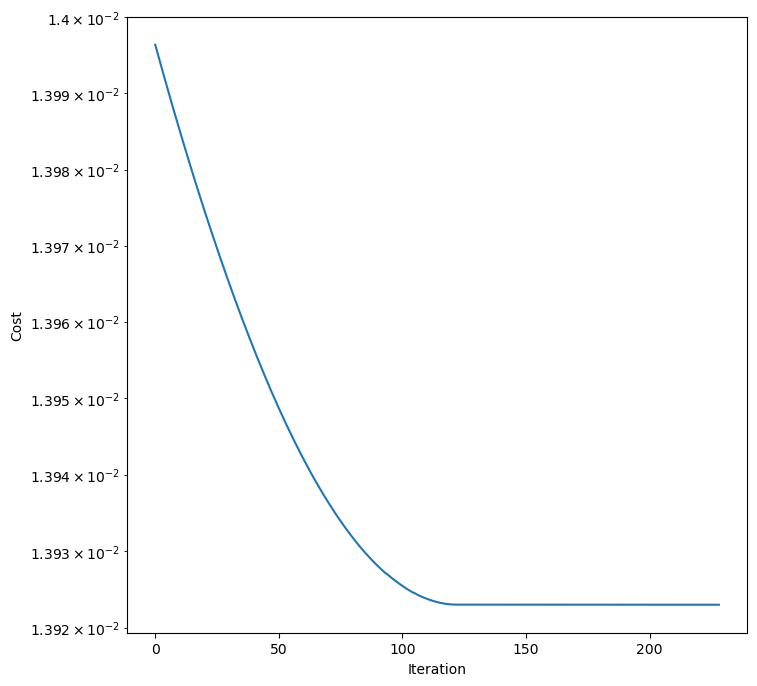

After optimization:  0.027775703971145708 7.033880291041226e-05 1.664492870763804


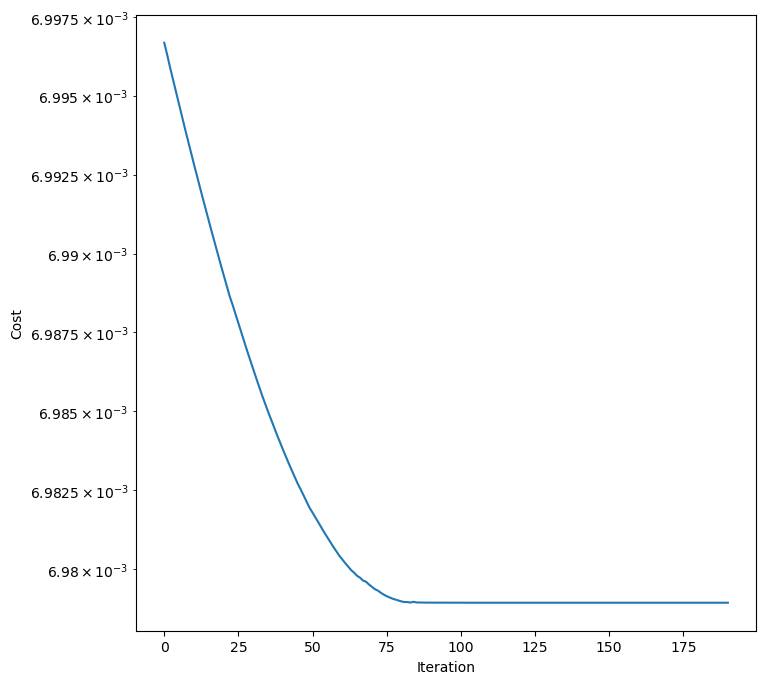

After optimization:  0.02786158522834763 1.8068044488995042e-05 1.6686376833770307


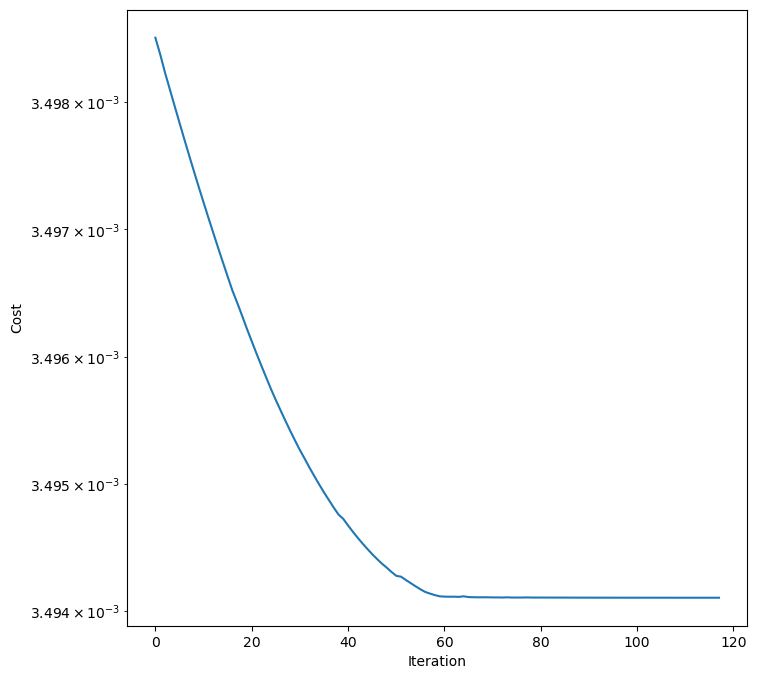

After optimization:  0.027920121059730543 4.675107773270323e-06 1.6707916073513558


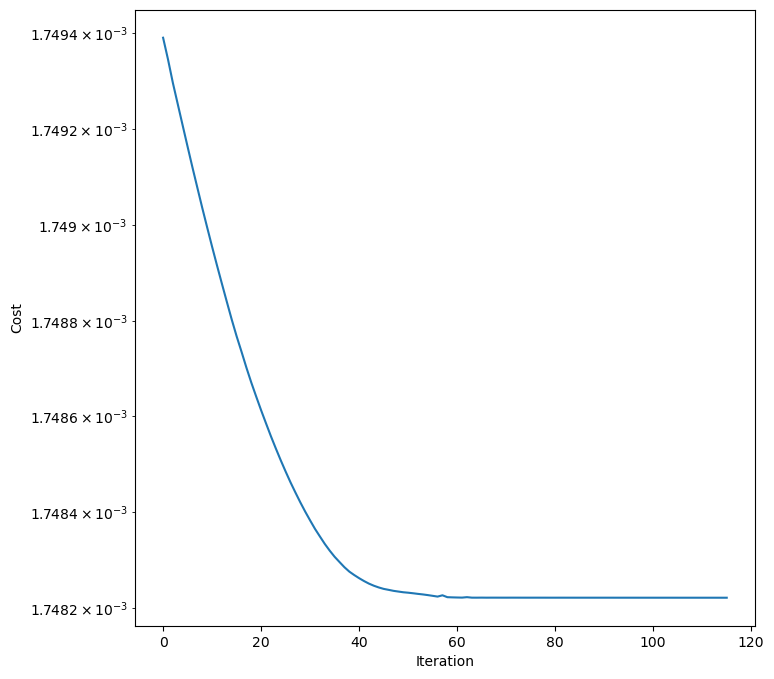

After optimization:  0.0279538710544915 1.1783443471003298e-06 1.67190587983129


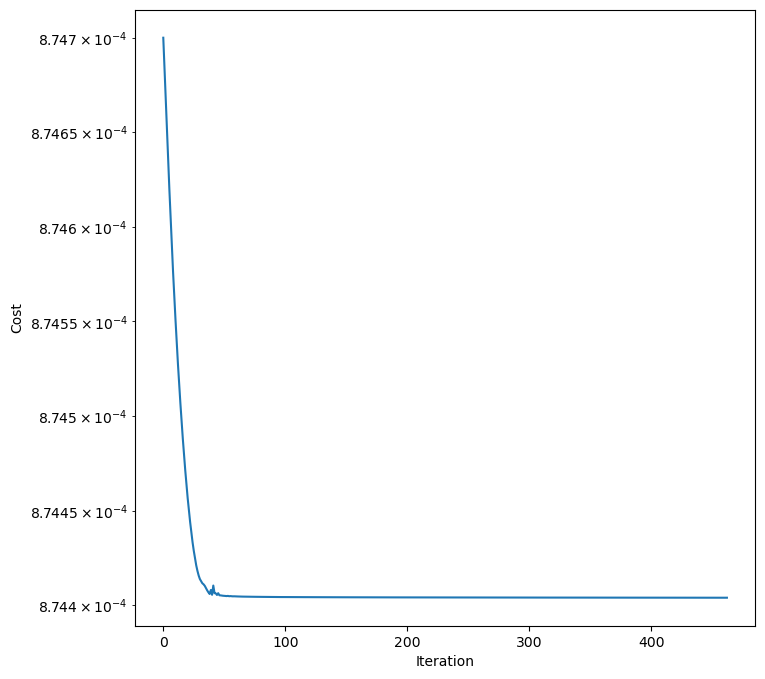

After optimization:  0.027971729404162156 2.966853724844602e-07 1.6724662244359279


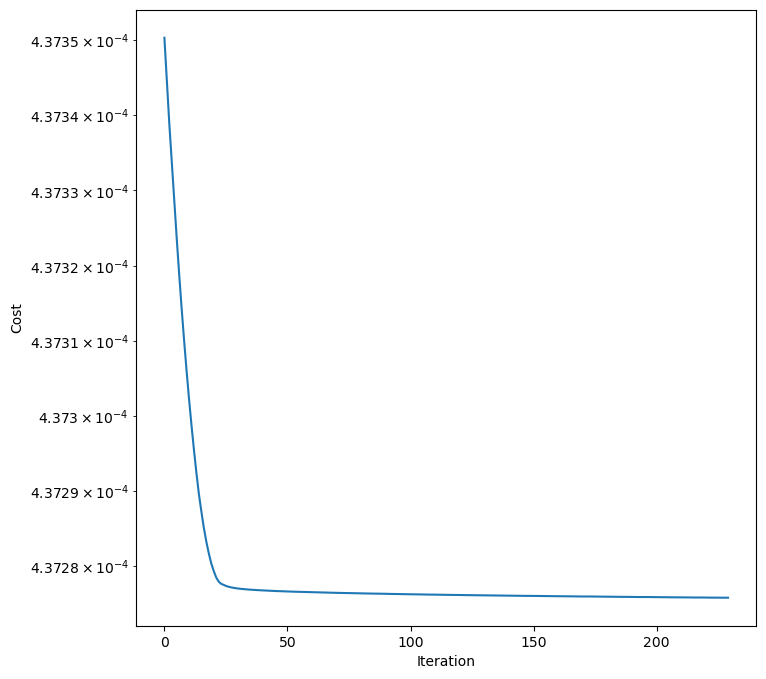

After optimization:  0.02798094228904253 7.477274674606745e-08 1.6727482630777348


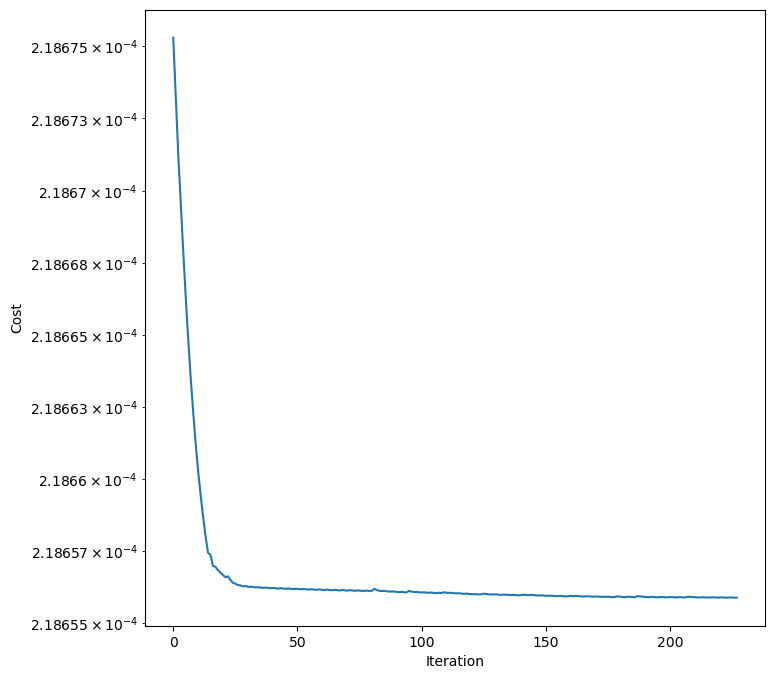

After optimization:  0.027985620775013775 1.8370225083956987e-08 1.6728897873078397


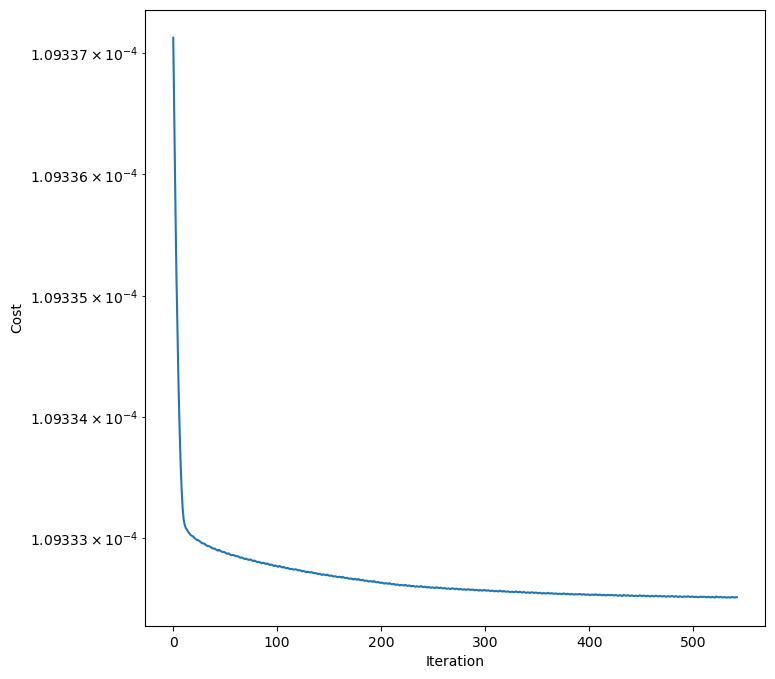

After optimization:  0.02798792093133284 4.711020607789852e-09 1.6729589421235727


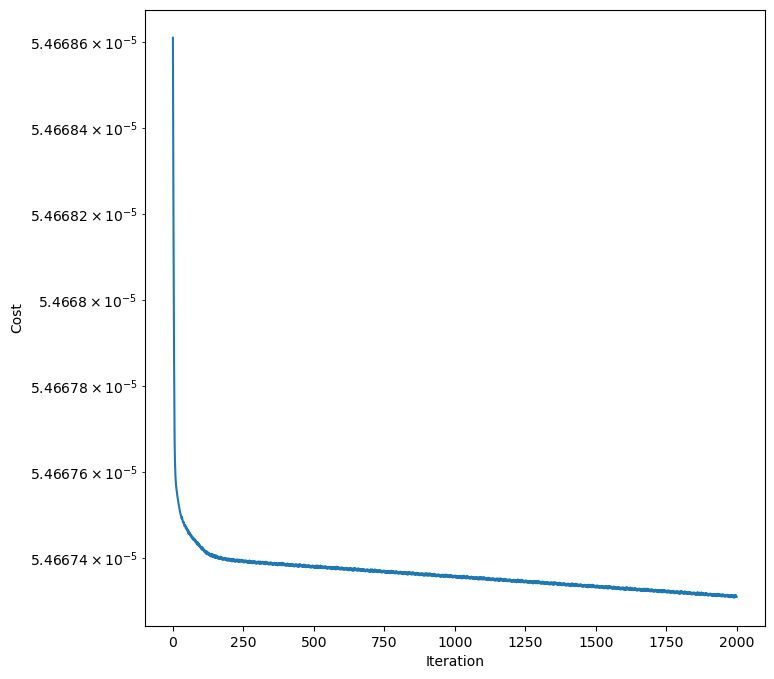

After optimization:  0.027989091585183014 1.1213490494405748e-09 1.6729940365654017


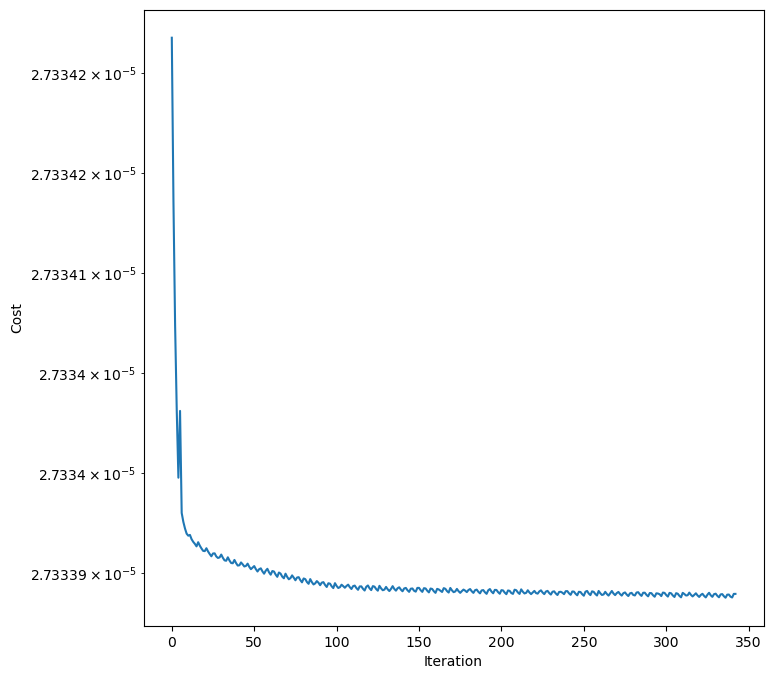

After optimization:  0.027989656836567834 2.9036084037248485e-10 1.6730109547222634


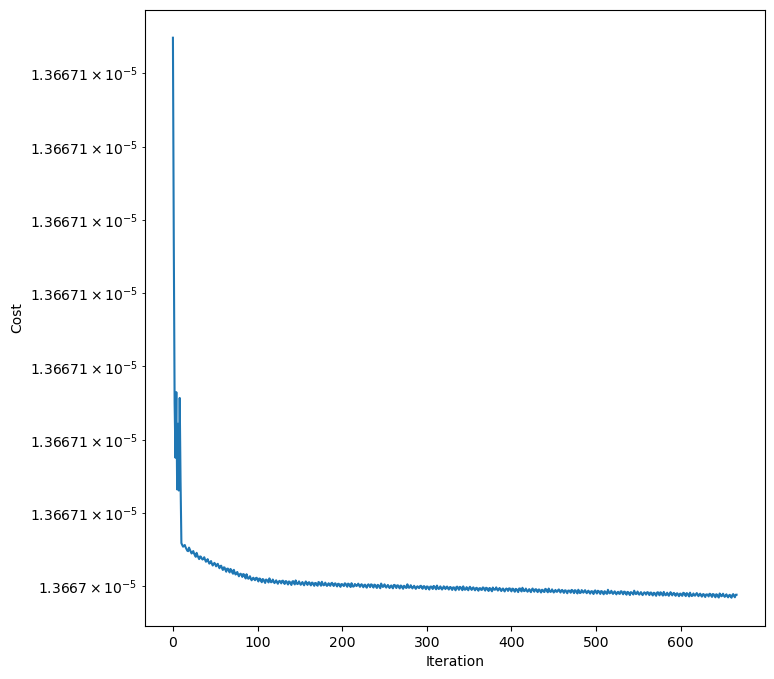

After optimization:  0.02798994781007241 7.218393375112768e-11 1.6730196573229041


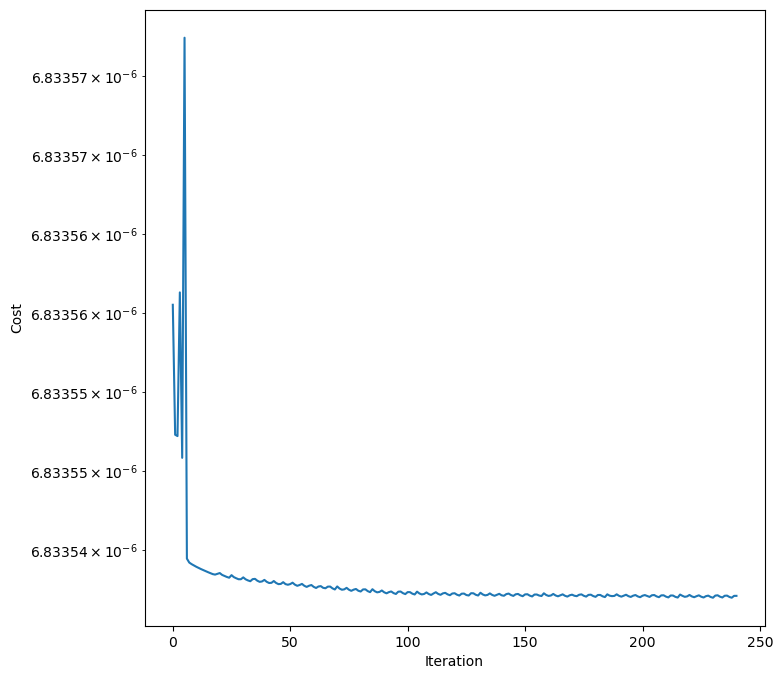

After optimization:  0.027990093359006776 1.822972962490146e-11 1.6730240088168802


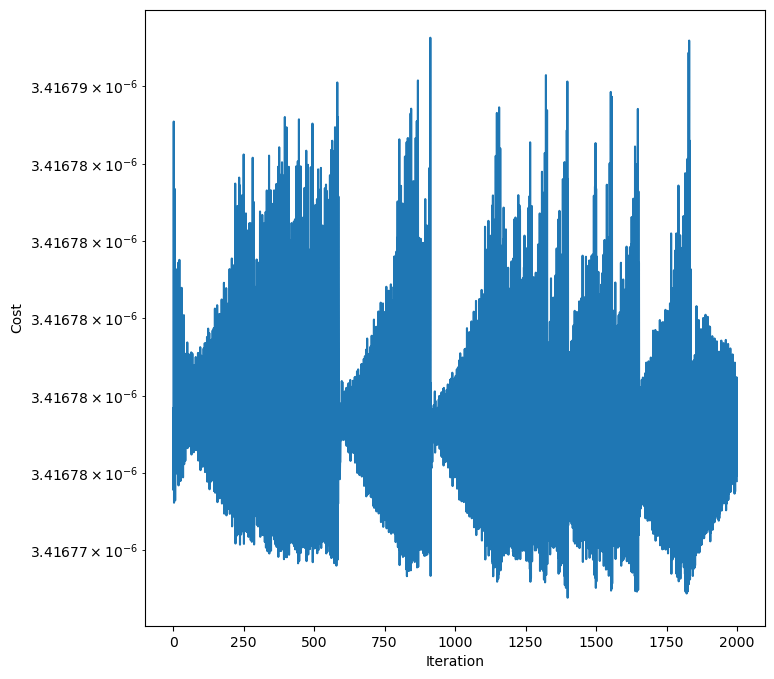

After optimization:  0.02799016681803153 1.065746284890454e-11 1.6730262044383544


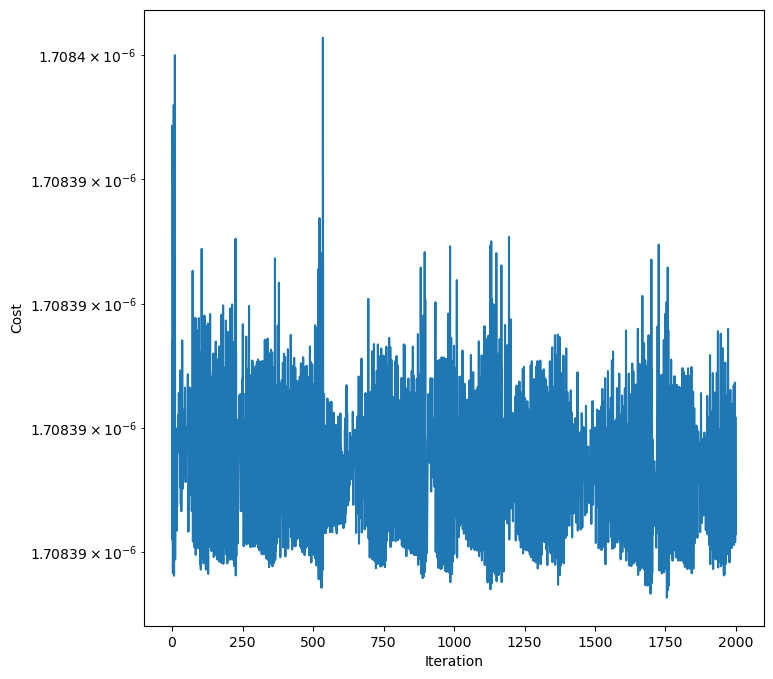

After optimization:  0.02799020485051907 3.997693073826686e-12 1.6730273412745345


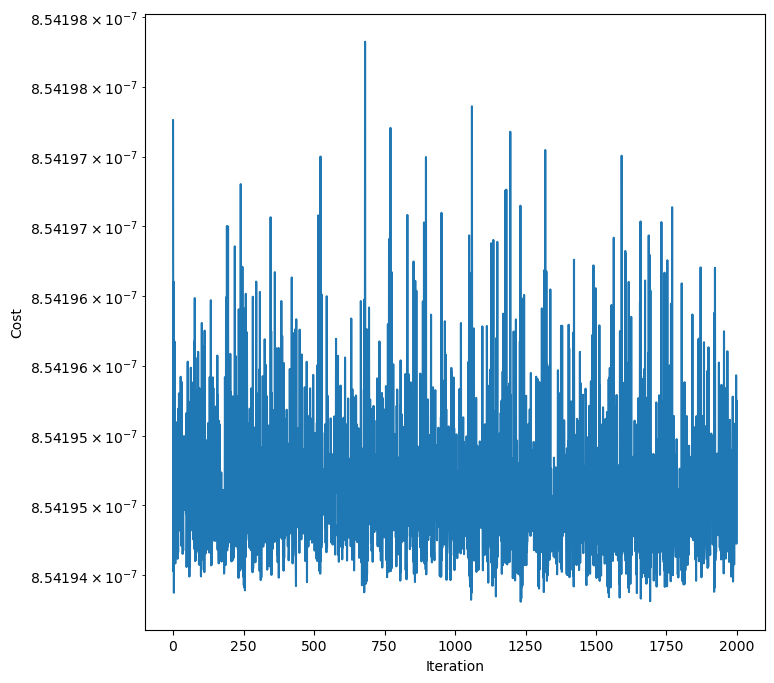

After optimization:  0.027990220104287304 1.7225163864397159e-13 1.6730277972620493


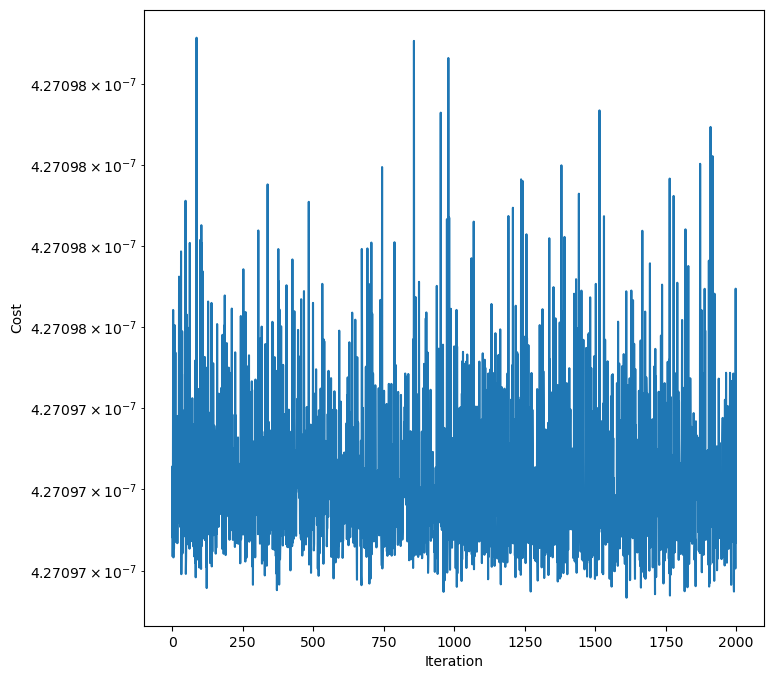

After optimization:  0.027990219187156974 3.9847794429614495e-13 1.6730277698459908


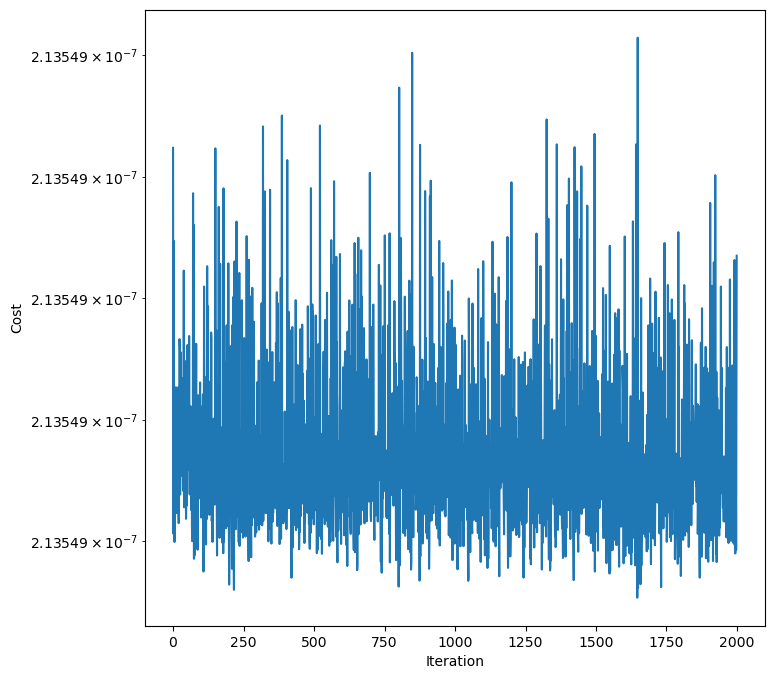

After optimization:  0.027990232047101885 5.476743652152594e-14 1.6730281541877026


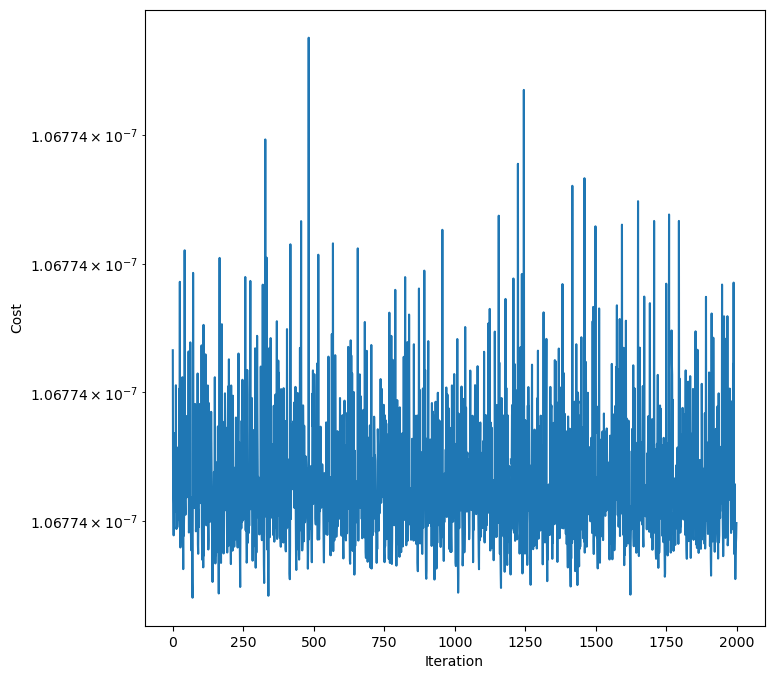

After optimization:  0.02799022361710182 2.791203511285863e-14 1.673027902250106


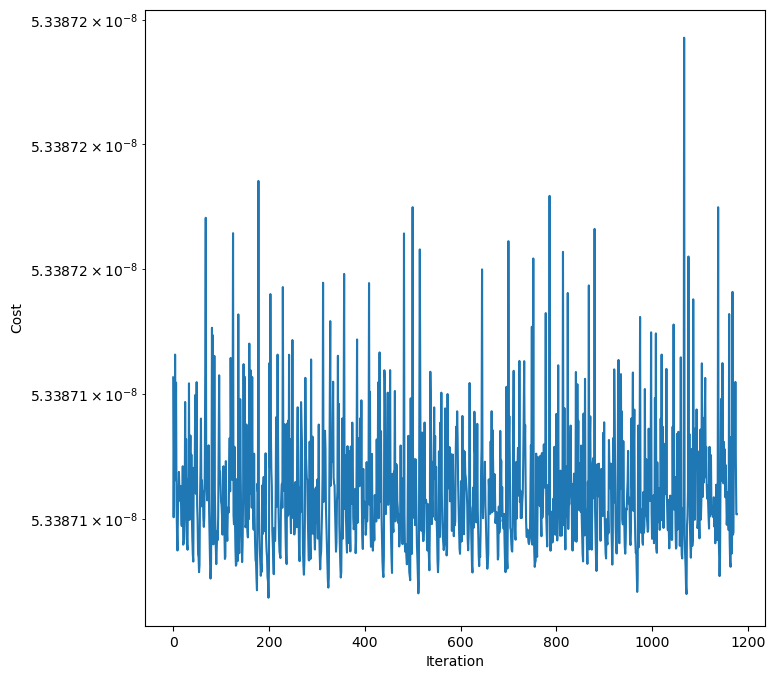

After optimization:  0.027990224566772578 4.151767510735664e-15 1.6730279306326128


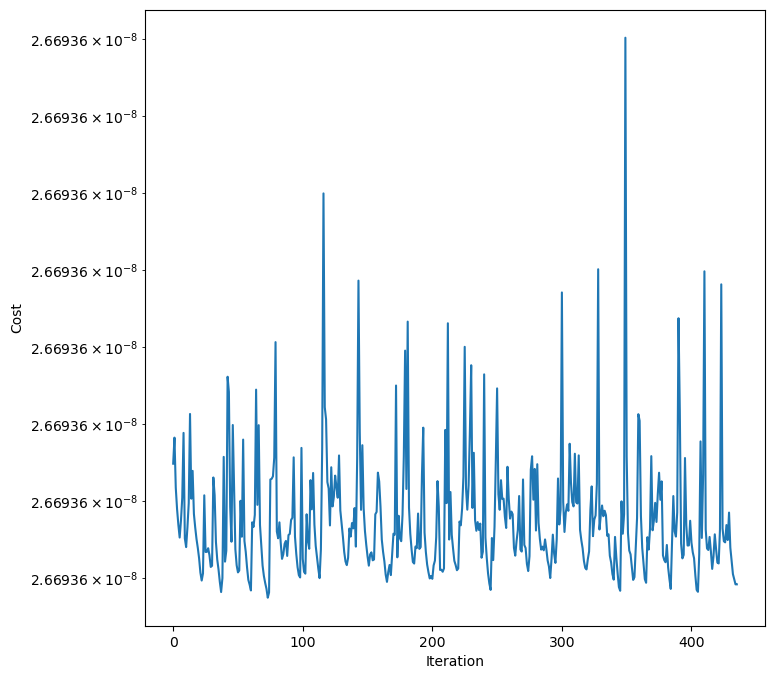

After optimization:  0.02799022058476797 1.136435363030838e-16 1.6730278116268078


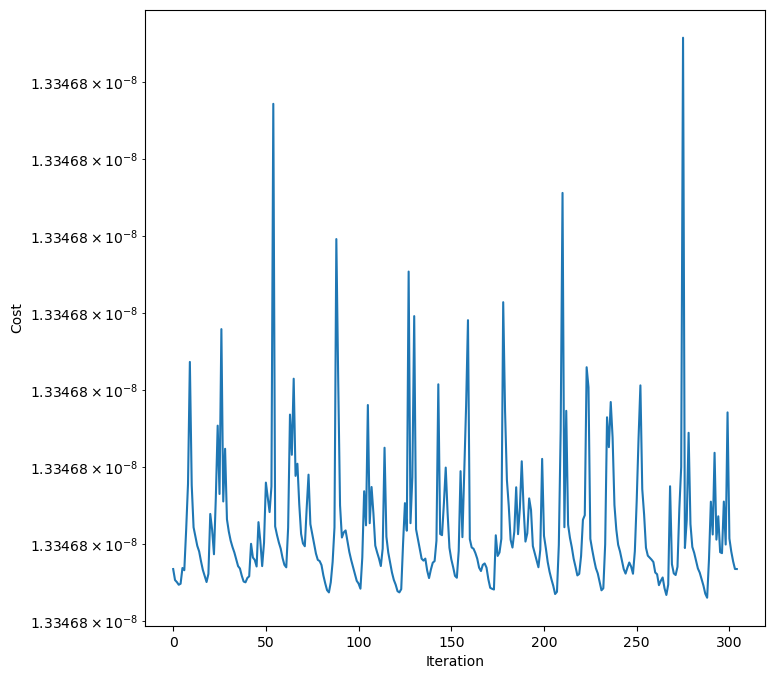

After optimization:  0.027990220565337804 1.2384171530341658e-16 1.6730278110461188


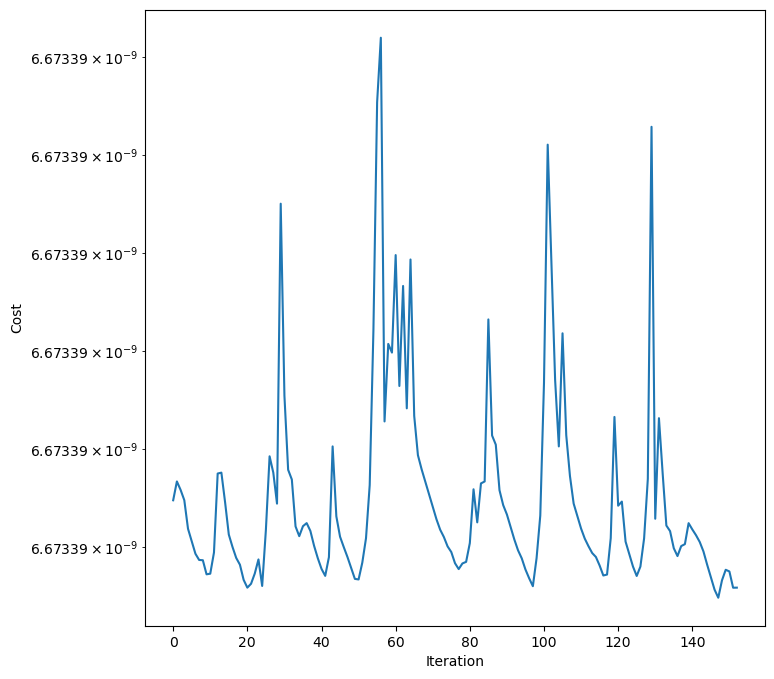

After optimization:  0.02799021880951778 9.711329634592272e-17 1.673027758571796


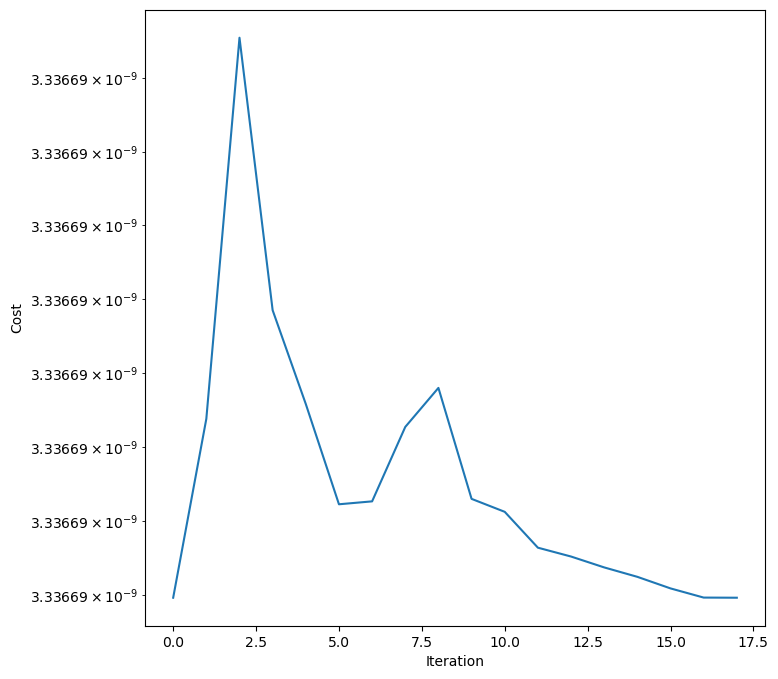

After optimization:  0.027990219523563165 1.1990990184859648e-17 1.673027779911713


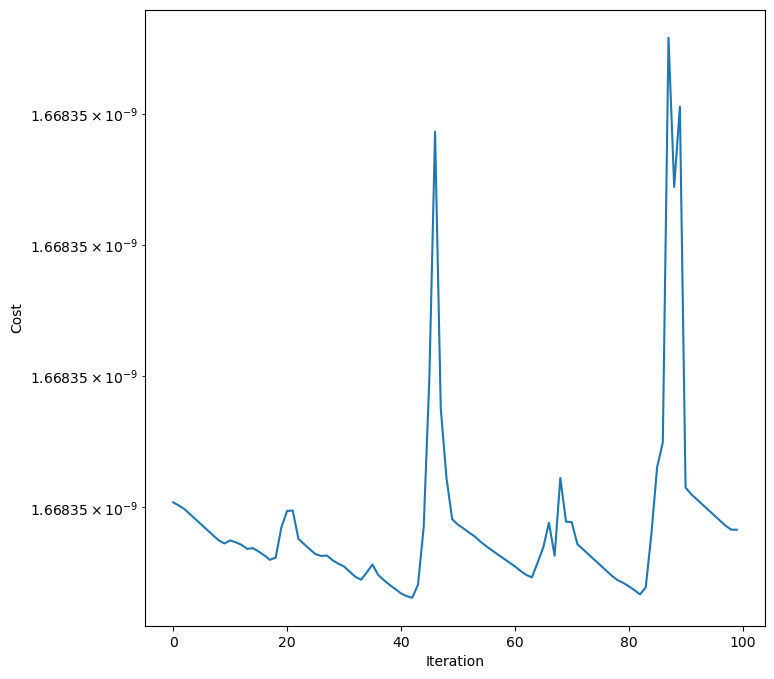

After optimization:  0.027990219326721716 2.827184801131324e-18 1.6730277740289223


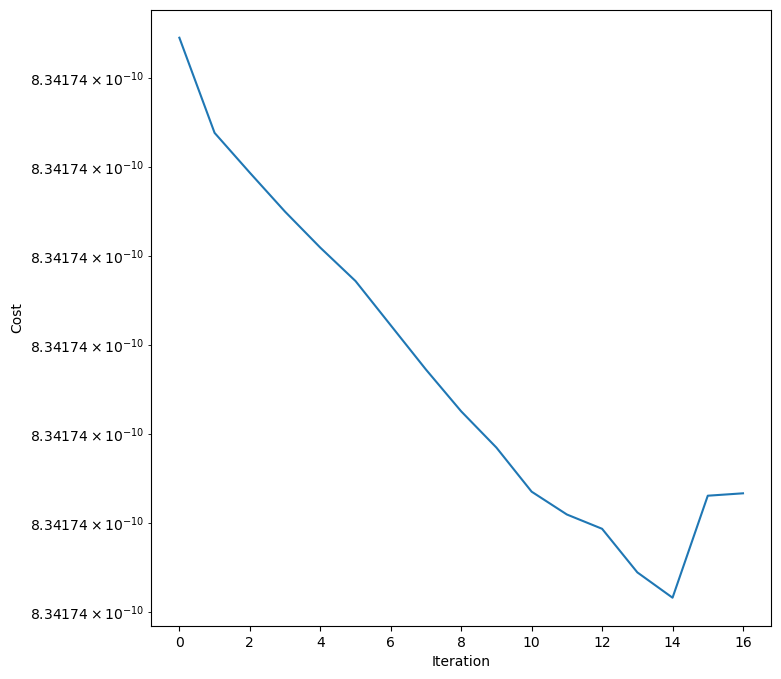

After optimization:  0.027990219004807967 2.1880297101688813e-18 1.673027764408229


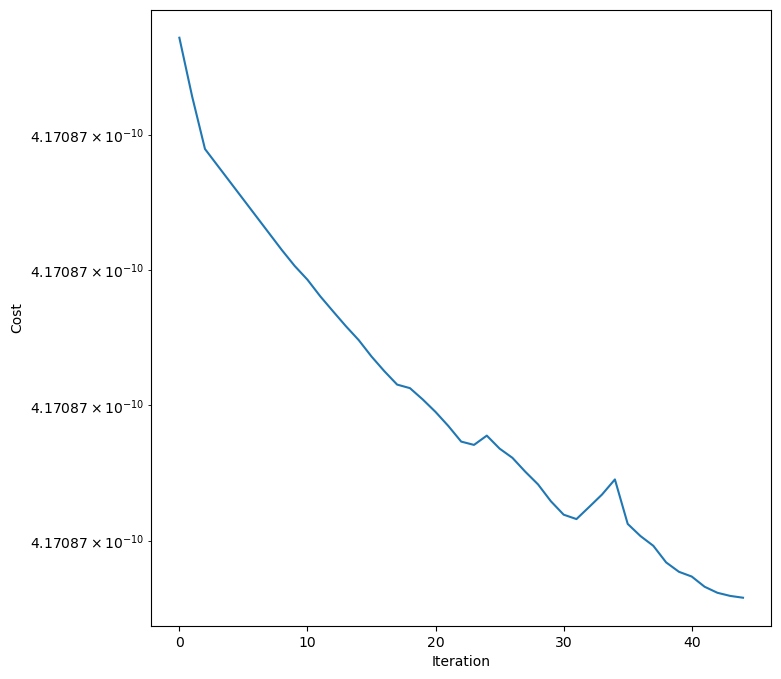

After optimization:  0.02799021858996172 1.0088493413790941e-19 1.6730277520101606


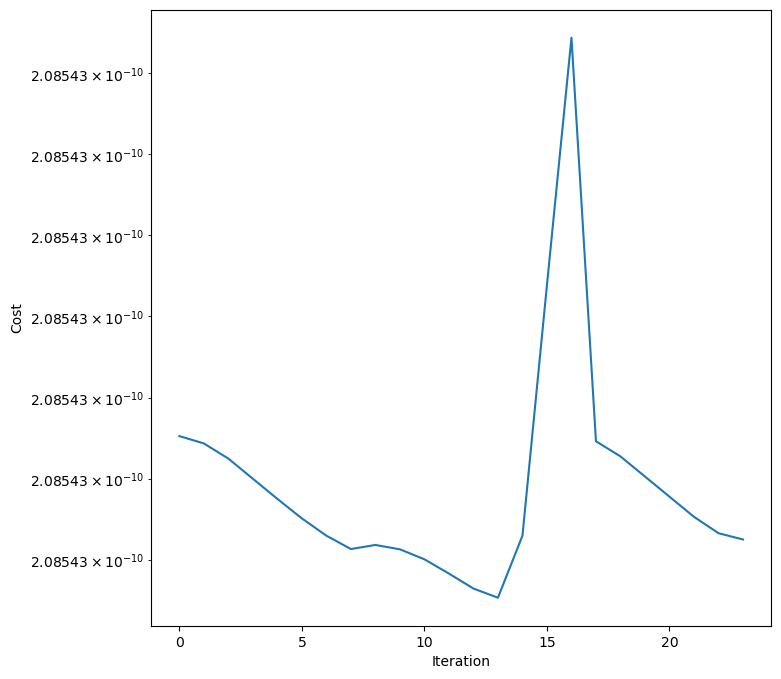

After optimization:  0.027990218556957994 2.7675957378749344e-20 1.6730277510238134


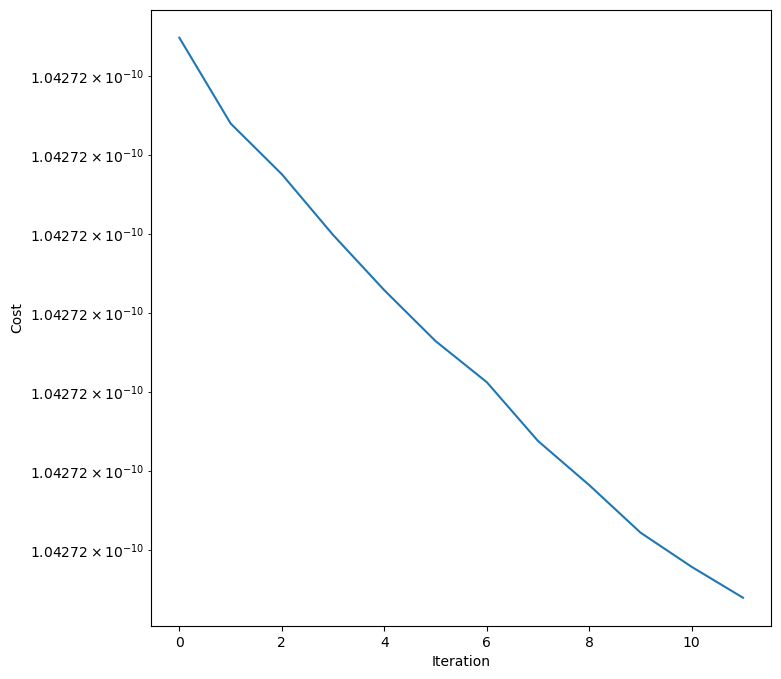

After optimization:  0.027990218526320658 0.0 1.673027750108188
Score of generated dataframe: 0.39986026441652356


In [ ]:
def legalize(sol, do_plot=False, move_factor=10., tolerance_rel_change=1e-7, stop_on_cost_increase = False, n_iter=20, target=1e-10, validate=True):
    assert sol.is_phenotype()
    solx = copy.deepcopy(sol)
    solx.use_fixed_h = False
    solx.snap()
    import pack_ga3
    ga = pack_ga3.baseline()
    cost = copy.deepcopy(ga.fitness_cost)
    cost.costs[2] = pack_cost.CollisionCostSeparation()
    #cost.costs[0].scaling*=0.1
    cost_overlap = copy.deepcopy(cost)
    cost_overlap.costs.pop(0)
    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = copy.deepcopy(cost)
    optimizer.n_iterations = 20000
    optimizer.max_step = None#1e-4
    optimizer.history_size = 10
    optimizer.tolerance_rel_change = tolerance_rel_change
    optimizer.track_cost = do_plot
    optimizer.plot_cost = do_plot
    optimizer.use_line_search = True
    optimizer.stop_on_cost_increase = stop_on_cost_increase
    print("Before optimization: ", cost.compute_cost_allocate(solx)[0].get().item(), cost_overlap.compute_cost_allocate(solx)[0].get().item(), solx.h[0,0])
    for _ in range(n_iter):
        optimizer.cost.costs[0].scaling*=0.5
        #optimizer.max_step*=0.5
        solx = optimizer.run_simulation(solx)
        optimizer.n_iterations = np.round(200*move_factor).astype(int)
        print("After optimization: ", cost.compute_cost_allocate(solx)[0].get().item(), cost_overlap.compute_cost_allocate(solx)[0].get().item(), solx.h[0,0])
        if cost_overlap.compute_cost_allocate(solx)[0].get().item()<target:
            break   
    try:
        if validate:
            solution_list_to_dataframe([solx], compact=False)
        else:
            assert cost_overlap.compute_cost_allocate(solx)[0].get().item()<target
        return solx
    except:
        if tolerance_rel_change==0.:
            raise Exception('Could not legalize solution')
        else:
            return legalize(solx, do_plot=do_plot, move_factor=move_factor, tolerance_rel_change=0., stop_on_cost_increase=stop_on_cost_increase, n_iter=n_iter, target=target, validate=validate)

sol2 = pack_io.legalize(sol, do_plot = True, validate=True, target = 1e-20, n_iter = 100, tolerance_rel_change=1e-10, line_search = True)

In [ ]:
pack_io.solution_list_to_dataframe([sol], compact=True);
pack_io.solution_list_to_dataframe([sol2], compact=True);

Starting binary search from h=1.673105
Iteration 1/50:


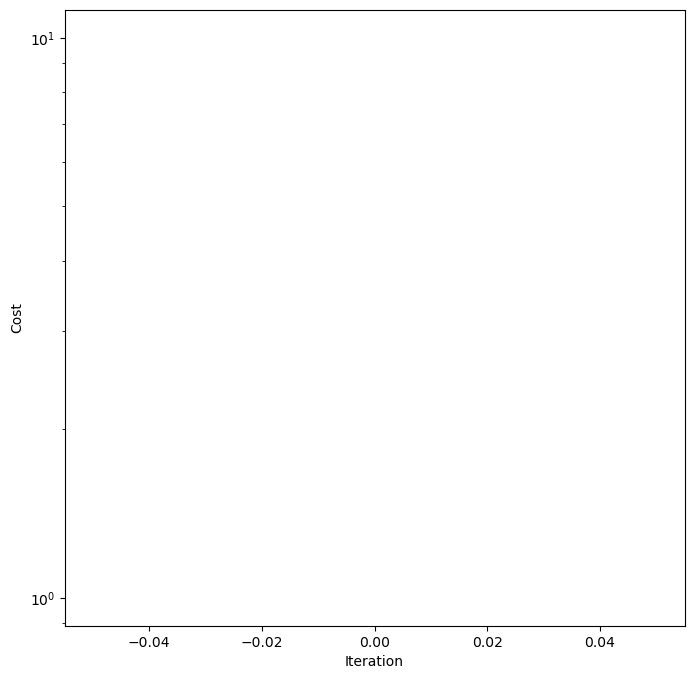

  h=1.673105 -> overlap=0.000e+00
  ✓ Success at h=1.673105, h²/N=0.399897

Iteration 2/50:


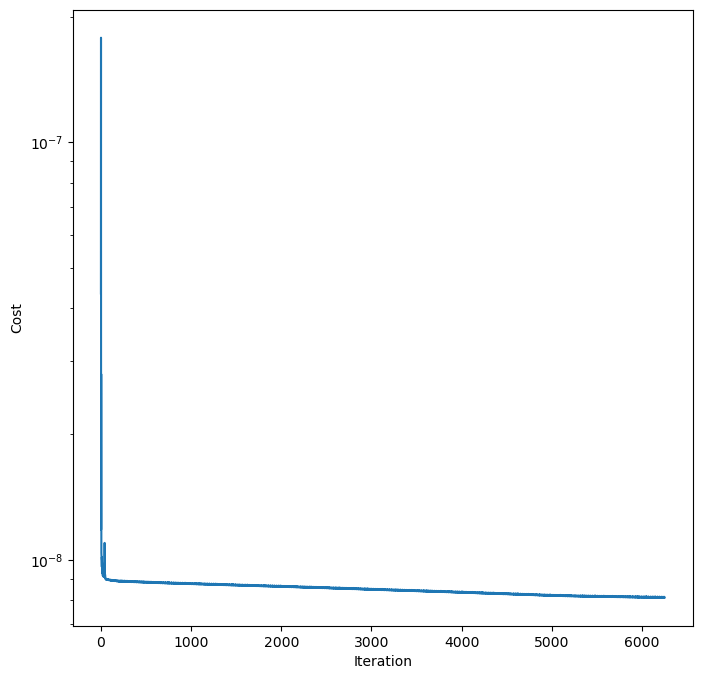

  h=1.672937 -> overlap=8.114e-09
  ✗ Failed at h=1.672937
  Binary search gap: 0.000100

Iteration 3/50:


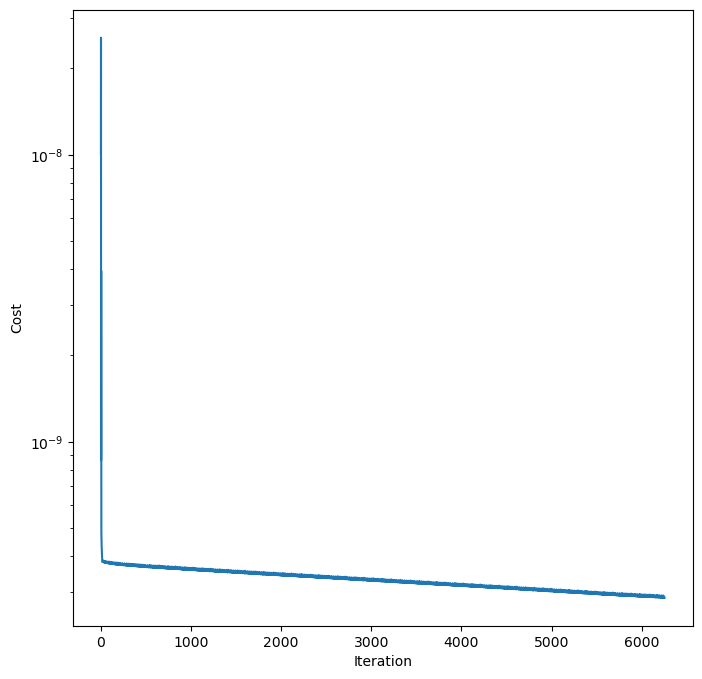

  h=1.673021 -> overlap=2.860e-10
  ✗ Failed at h=1.673021
  Binary search gap: 0.000050

Iteration 4/50:


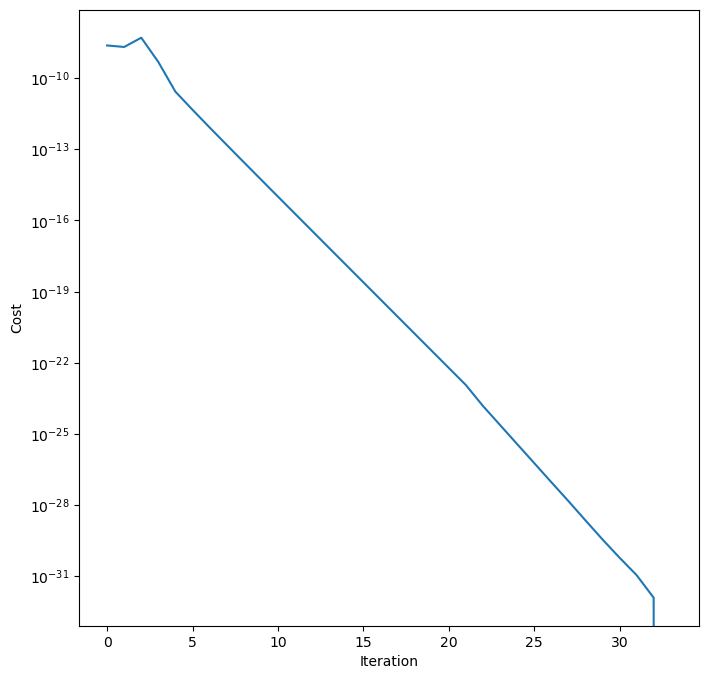

  h=1.673063 -> overlap=0.000e+00
  ✓ Success at h=1.673063, h²/N=0.399877
  Binary search gap: 0.000025

Iteration 5/50:


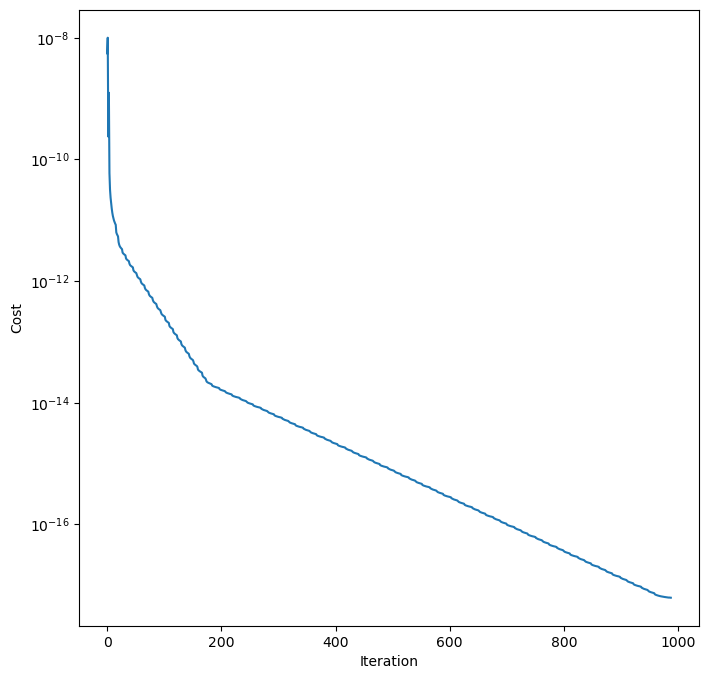

  h=1.673042 -> overlap=6.174e-18
  ✗ Failed at h=1.673042
  Binary search gap: 0.000013

Iteration 6/50:


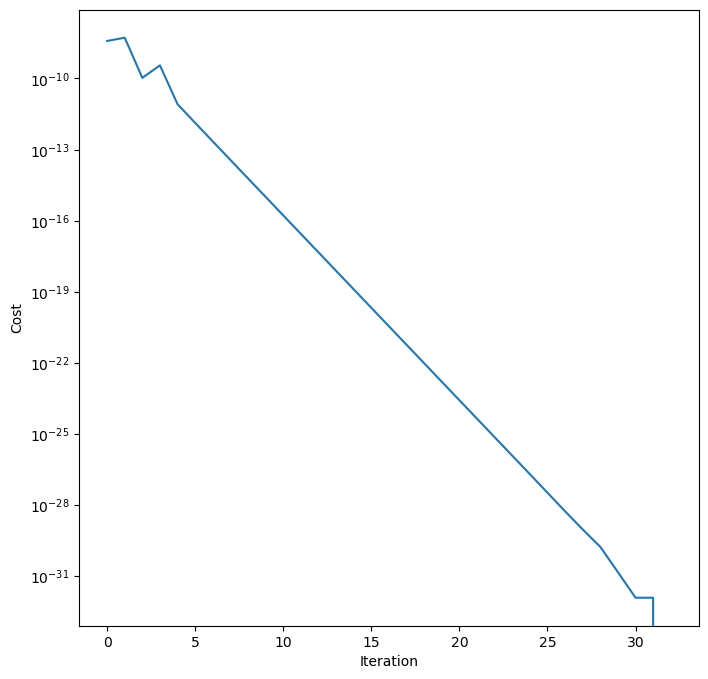

  h=1.673052 -> overlap=0.000e+00
  ✓ Success at h=1.673052, h²/N=0.399872
  Binary search gap: 0.000006

Iteration 7/50:


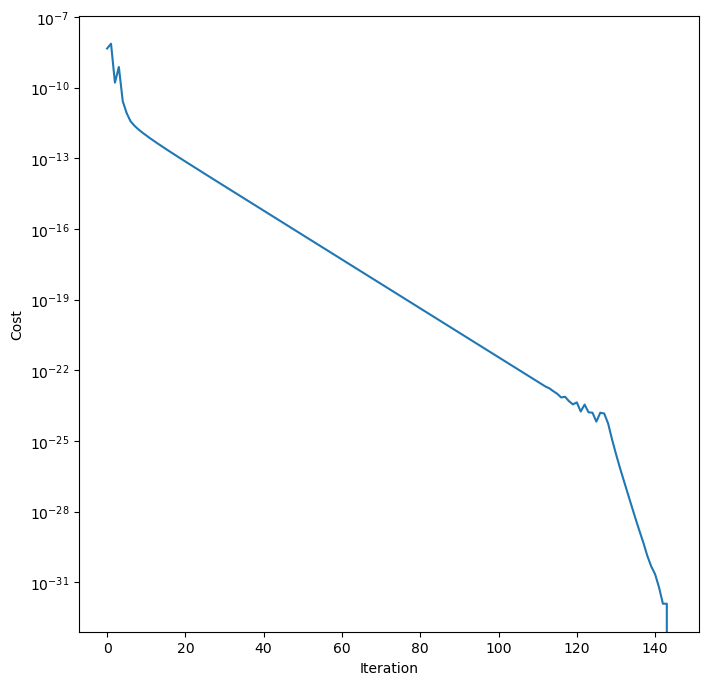

  h=1.673047 -> overlap=0.000e+00
  ✓ Success at h=1.673047, h²/N=0.399870
  Binary search gap: 0.000003

Iteration 8/50:


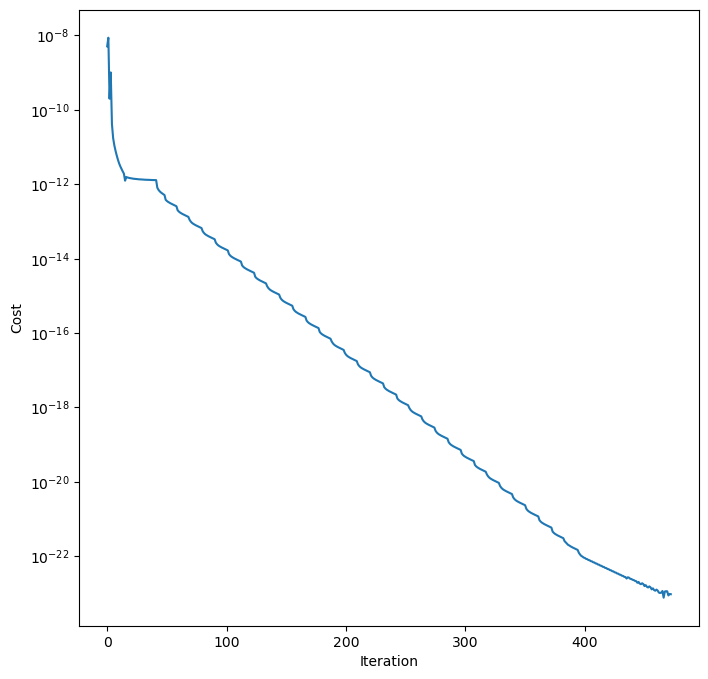

  h=1.673044 -> overlap=9.679e-24
  ✓ Success at h=1.673044, h²/N=0.399868
  Binary search gap: 0.000002

Iteration 9/50:


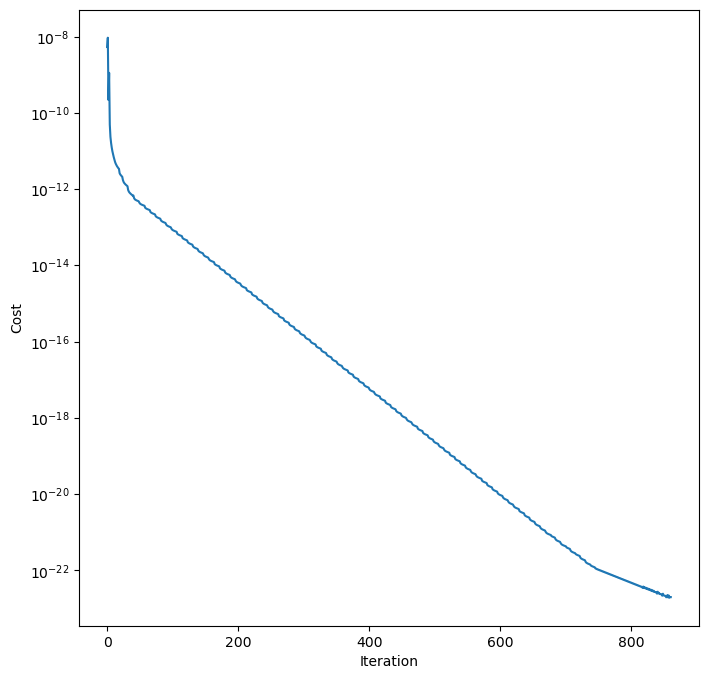

  h=1.673043 -> overlap=2.017e-23
  ✓ Success at h=1.673043, h²/N=0.399868
  Binary search gap: 0.000001

Iteration 10/50:


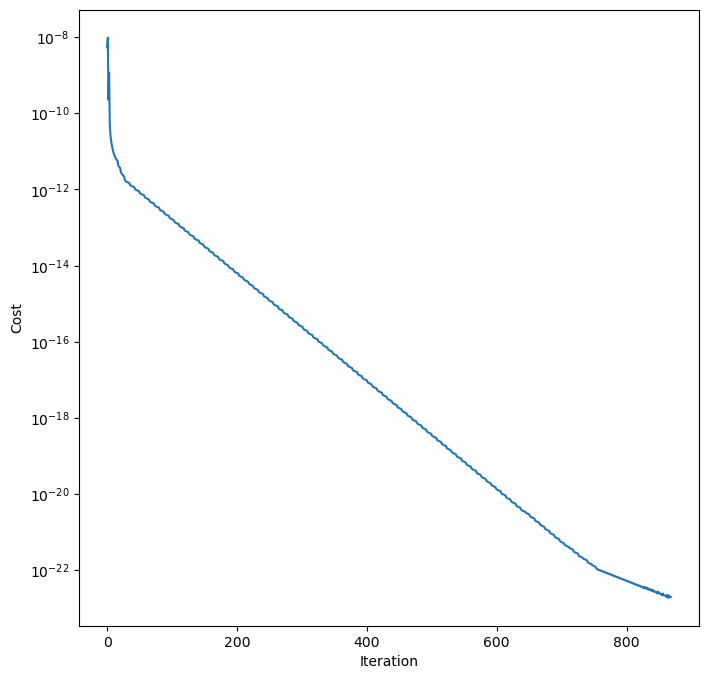

  h=1.673043 -> overlap=2.009e-23
  ✓ Success at h=1.673043, h²/N=0.399867
  Binary search gap: 0.000000

Iteration 11/50:


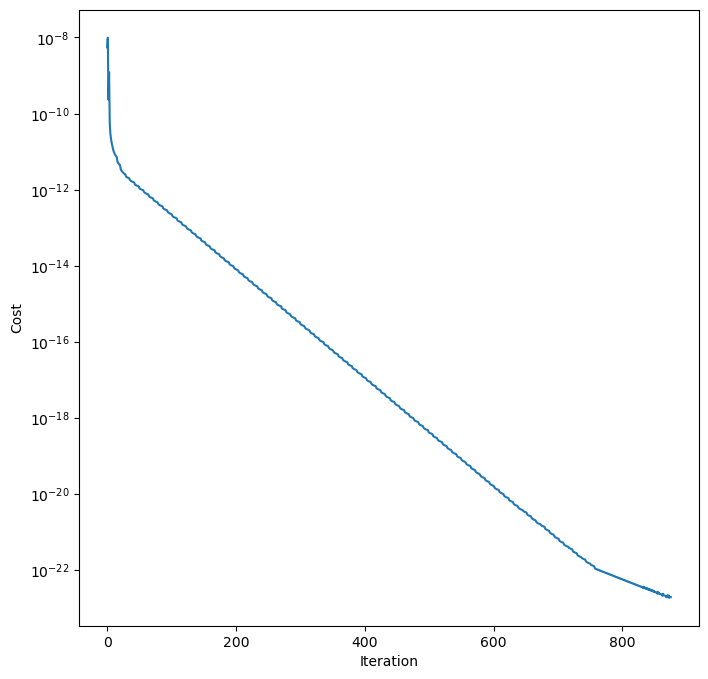

  h=1.673042 -> overlap=1.968e-23
  ✓ Success at h=1.673042, h²/N=0.399867
  Binary search gap: 0.000000

Iteration 12/50:


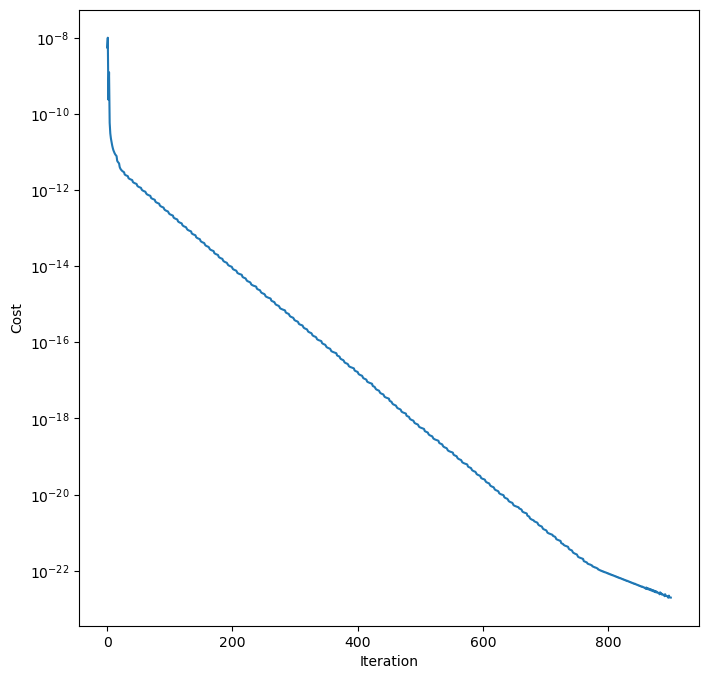

  h=1.673042 -> overlap=1.989e-23
  ✓ Success at h=1.673042, h²/N=0.399867
  Binary search gap: 0.000000

✓ Converged!
Final: h=1.673042, h²/N=0.399867


In [21]:
def legalize_binsearch(sol, do_plot=False, target_overlap=1e-20, max_iterations=20, h_reduction_factor=0.999):
    """
    Binary search on h to find minimum value allowing zero overlap:
    1. Fix h, try to eliminate overlaps
    2. If successful -> reduce h and try again
    3. If unsuccessful -> increase h (binary search between last good and current)
    """
    assert sol.is_phenotype()
    solx = copy.deepcopy(sol)
    solx.snap()
    
    import pack_ga3
    ga = pack_ga3.baseline()
    cost_base = copy.deepcopy(ga.fitness_cost)
    cost_base.costs[2] = pack_cost.CollisionCostSeparation()
    
    # Cost for eliminating overlaps (no area term, just collision)
    cost_overlap_only = pack_cost.CollisionCostOverlappingArea(scaling=1.0)
    
    def try_eliminate_overlap(sol_input, h_value, verbose=True):
        """Try to find zero-overlap configuration at fixed h"""
        sol_try = copy.deepcopy(sol_input)
        sol_try.h[0, 0] = h_value
        sol_try.use_fixed_h = True
        sol_try.snap()
        
        opt = pack_dynamics.OptimizerBFGS()
        opt.cost = cost_base
        opt.n_iterations = 5000
        opt.max_step = None
        opt.history_size = 10
        opt.tolerance_rel_change = 0.
        opt.track_cost = False
        opt.use_line_search = True
        opt.track_cost = do_plot
        opt.plot_cost = do_plot
        
        sol_result = opt.run_simulation(sol_try)
        overlap = cost_base.compute_cost_allocate(sol_result)[0].get().item()
        
        if verbose:
            print(f"  h={h_value:.6f} -> overlap={overlap:.3e}")
        
        return sol_result, overlap <= target_overlap
    
    # Start with current h
    current_h = solx.h[0, 0].get().item()
    best_sol = solx
    best_h = current_h
    last_good_h = None
    last_bad_h = None
    
    print(f"Starting binary search from h={current_h:.6f}")
    #print(f"Target: h²/N < {theirs:.6f}\n")
    
    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}:")
        
        # Try to eliminate overlap at current h
        result_sol, success = try_eliminate_overlap(solx, current_h)
        
        if success:
            # Success! This h works
            print(f"  ✓ Success at h={current_h:.6f}, h²/N={current_h**2/solx.N_trees:.6f}")
            best_sol = result_sol
            best_h = current_h
            last_good_h = current_h
            
            # Try to go smaller
            if last_bad_h is not None:
                # Binary search between last_bad_h and current_h
                current_h = (last_bad_h + current_h) / 2
            else:
                # No bad h yet, just reduce by factor
                current_h *= h_reduction_factor
                
        else:
            # Failed - h is too small
            print(f"  ✗ Failed at h={current_h:.6f}")
            last_bad_h = current_h
            
            if last_good_h is not None:
                # Binary search between last_good_h and current_h
                current_h = (last_good_h + current_h) / 2
            else:
                # No good h yet, increase
                current_h *= 1.05
        
        # Check convergence
        if last_good_h is not None and last_bad_h is not None:
            gap = abs(last_good_h - last_bad_h) / last_good_h
            print(f"  Binary search gap: {gap:.6f}")
            if gap < 0.0000001:  # 0.1% convergence
                print(f"\n✓ Converged!")
                break
        
        print()
    
    final_h = best_h
    print(f"Final: h={final_h:.6f}, h²/N={final_h**2/solx.N_trees:.6f}")
    #print(f"Improvement vs theirs: {(final_h**2/solx.N_trees - theirs)/theirs*100:+.2f}%")
    
    return best_sol

# Test binary search approach
sol3 = legalize_binsearch(sol, h_reduction_factor=0.9999, max_iterations=50, do_plot = True)

In [25]:
# Compare all approaches
print(f"Original (mine):        {mine:.6f}")
print(f"Their solution:         {theirs:.6f}")
print(f"Your complex approach:  {sol2.h[0,0].get().item()**2/sol2.N_trees:.6f}")
print(f"Simple two-phase:       {sol3.h[0,0].get().item()**2/sol3.N_trees:.6f}")

Original (mine):        0.399897
Their solution:         0.399897
Your complex approach:  0.399860
Simple two-phase:       0.399867


In [26]:
pack_io.solution_list_to_dataframe([sol], compact=True);
pack_io.solution_list_to_dataframe([sol2], compact=True);
pack_io.solution_list_to_dataframe([sol3], compact=True);

Score of generated dataframe: 0.3998863152828664
Score of generated dataframe: 0.39986026225468346
Score of generated dataframe: 0.3998670976519971
